# Introduction

In a prior notebook, documents were partitioned by assigning them to the domain with the highest Dice similarity of their term and structure occurrences. The occurrences of terms and structures in each domain is what we refer to as the domain "archetype." Here, we'll assess whether the observed similarity between documents and the archetype is greater than expected by chance. This would indicate that information in the framework generalizes well to individual documents.

# Load the data

In [1]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.append("..")
import utilities
from ontology import ontology
from style import style

In [2]:
version = 190325 # Document-term matrix version
clf = "lr" # Classifier used to generate the framework
suffix = "_" + clf # Suffix for term lists
n_iter = 1000 # Iterations for null distribution
circuit_counts = range(2, 51) # Range of k values

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Document splits

In [5]:
splits = {}
# splits["train"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["validation"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["test"] = [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, split_pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(split_pmids)))

Validation   N=3631
Test         N=1816


In [6]:
pmids = dtm_bin.index.intersection(act_bin.index)

## Document assignments and distances

Indexing by min:max will be faster in subsequent computations

In [7]:
from collections import OrderedDict
from scipy.spatial.distance import cdist

In [8]:
def load_doc2dom(k, clf="lr"):
    doc2dom_df = pd.read_csv("../partition/data/doc2dom_k{:02d}_{}.csv".format(k, clf), 
                             header=None, index_col=0)
    doc2dom = {int(pmid): str(dom.values[0]) for pmid, dom in doc2dom_df.iterrows()}
    return doc2dom

def load_dom2docs(k, domains, splits, clf="lr"):
    doc2dom = load_doc2dom(k, clf=clf)
    dom2docs = {dom: {split: [] for split, _ in splits.items()} for dom in domains}
    for doc, dom in doc2dom.items():
        for split, split_pmids in splits.items():
            if doc in splits[split]:
                dom2docs[dom][split].append(doc)
    return dom2docs

In [9]:
sorted_pmids, doc_dists, dom_idx = {}, {}, {}
for k in circuit_counts:
    
    print("Processing k={:02d}".format(k))
    sorted_pmids[k], doc_dists[k], dom_idx[k] = {}, {}, {}
    
    for split, split_pmids in splits.items():
        
        lists, circuits = ontology.load_ontology(k, path="../ontology/", suffix=suffix)
        words = sorted(list(set(lists["TOKEN"])))
        structures = sorted(list(set(act_bin.columns)))
        domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

        dtm_words = dtm_bin.loc[pmids, words]
        act_structs = act_bin.loc[pmids, structures]
        docs = dtm_words.copy()
        docs[structures] = act_structs.copy()

        doc2dom = load_doc2dom(k, clf=clf)
        dom2docs = load_dom2docs(k, domains, splits, clf=clf)

        ids = []
        for dom in domains:
            ids += [pmid for pmid, sys in doc2dom.items() if sys == dom and pmid in split_pmids]
        sorted_pmids[k][split] = ids

        doc_dists[k][split] = pd.DataFrame(cdist(docs.loc[ids], docs.loc[ids], metric="dice"),
                                           index=ids, columns=ids)

        dom_idx[k][split] = {}
        for dom in domains:
            dom_idx[k][split][dom] = {}
            dom_pmids = dom2docs[dom][split]
            if len(dom_pmids) > 0:
                dom_idx[k][split][dom]["min"] = sorted_pmids[k][split].index(dom_pmids[0])
                dom_idx[k][split][dom]["max"] = sorted_pmids[k][split].index(dom_pmids[-1]) + 1
            else:
                dom_idx[k][split][dom]["min"] = 0
                dom_idx[k][split][dom]["max"] = 0

Processing k=02
Processing k=03
Processing k=04
Processing k=05
Processing k=06
Processing k=07
Processing k=08
Processing k=09
Processing k=10
Processing k=11
Processing k=12
Processing k=13
Processing k=14
Processing k=15
Processing k=16
Processing k=17
Processing k=18
Processing k=19
Processing k=20
Processing k=21
Processing k=22
Processing k=23
Processing k=24
Processing k=25
Processing k=26
Processing k=27
Processing k=28
Processing k=29
Processing k=30
Processing k=31
Processing k=32
Processing k=33
Processing k=34
Processing k=35
Processing k=36
Processing k=37
Processing k=38
Processing k=39
Processing k=40
Processing k=41
Processing k=42
Processing k=43
Processing k=44
Processing k=45
Processing k=46
Processing k=47
Processing k=48
Processing k=49
Processing k=50


# Index by PMID and sort by structure

In [10]:
structures = sorted(list(set(act_bin.columns)))
act_structs = act_bin.loc[pmids, structures]

# Compute domain modularity

## Observed values

## Distances internal and external to articles in each domain

In [17]:
dists_int, dists_ext = {}, {}    
for k in circuit_counts:

    dists_int[k], dists_ext[k] = {}, {}
    lists, circuits = ontology.load_ontology(k, path="../ontology/", suffix=suffix)
    domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

    for split, split_pmids in splits.items():
        dists_int[k][split], dists_ext[k][split] = {}, {}
        
        for dom in domains:

            dom_min, dom_max = dom_idx[k][split][dom]["min"], dom_idx[k][split][dom]["max"]
            dom_dists = doc_dists[k][split].values[:,dom_min:dom_max][dom_min:dom_max,:]
            dists_int[k][split][dom] = dom_dists

            other_dists_lower = doc_dists[k][split].values[:,dom_min:dom_max][:dom_min,:]
            other_dists_upper = doc_dists[k][split].values[:,dom_min:dom_max][dom_max:,:]
            other_dists = np.concatenate((other_dists_lower, other_dists_upper))
            dists_ext[k][split][dom] = other_dists

## Domain-averaged ratio of external to internal distances

In [18]:
means = {split: np.empty((len(circuit_counts),)) for split in splits.keys()}

for k_i, k in enumerate(circuit_counts):
    
    file_obs = "data/kvals/mod_obs_k{:02d}_{}_{}.csv".format(k, clf, split)
    if not os.path.isfile(file_obs):
        
        print("Processing k={:02d}".format(k))
    
        lists, circuits = ontology.load_ontology(k, path="../ontology/", suffix=suffix)
        domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))
        dom2docs = load_dom2docs(k, domains, splits, clf=clf)
                
        pmid_list, split_list, dom_list, obs_list  = [], [], [], []
        for split, split_pmids in splits.items():
            for dom in domains:

                n_dom_docs = dists_int[k][split][dom].shape[0]
                if n_dom_docs > 0:

                    mean_dist_int = np.nanmean(dists_int[k][split][dom], axis=0)
                    mean_dist_ext = np.nanmean(dists_ext[k][split][dom], axis=0)
                    ratio = mean_dist_ext / mean_dist_int
                    ratio[ratio == np.inf] = np.nan 

                    pmid_list += dom2docs[dom][split]
                    dom_list += [dom] * len(ratio)
                    split_list += [split] * len(ratio)
                    obs_list += list(ratio)

        df_obs = pd.DataFrame({"PMID": pmid_list, "SPLIT": split_list, 
                               "DOMAIN": dom_list, "OBSERVED": obs_list})
        df_obs.to_csv(file_obs, index=None)  
    
    else:
        df_obs = pd.read_csv(file_obs)
    
    for split, split_pmids in splits.items():
        dom_means = []
        for dom in set(df_obs["DOMAIN"]):
            dom_vals = df_obs.loc[(df_obs["SPLIT"] == split) & (df_obs["DOMAIN"] == dom), "OBSERVED"]
            dom_means.append(np.nanmean(dom_vals))
        means[split][k_i] = np.nanmean(dom_means)

Processing k=02
Processing k=03
Processing k=04
Processing k=05
Processing k=06
Processing k=07
Processing k=08
Processing k=09
Processing k=10
Processing k=11
Processing k=12
Processing k=13
Processing k=14


/anaconda3/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


Processing k=15
Processing k=16
Processing k=17
Processing k=18
Processing k=19
Processing k=20
Processing k=21
Processing k=22
Processing k=23
Processing k=24
Processing k=25
Processing k=26
Processing k=27
Processing k=28
Processing k=29
Processing k=30
Processing k=31
Processing k=32
Processing k=33
Processing k=34
Processing k=35
Processing k=36
Processing k=37
Processing k=38
Processing k=39
Processing k=40
Processing k=41
Processing k=42
Processing k=43
Processing k=44
Processing k=45
Processing k=46
Processing k=47
Processing k=48
Processing k=49
Processing k=50


## Null distributions

In [19]:
nulls = {split: np.empty((len(circuit_counts),n_iter)) for split in splits.keys()}

for split, split_pmids in splits.items():
    for k_i, k in enumerate(circuit_counts):

        file_null = "data/kvals/mod_null_k{:02d}_{}_{}iter.csv".format(k, split, n_iter)
        if not os.path.isfile(file_null):

            print("Processing k={:02d}".format(k))

            lists, circuits = ontology.load_ontology(k, path="../ontology/", suffix=suffix)
            domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

            n_docs = len(split_pmids)
            df_null = np.empty((len(domains), n_iter))
            for i, dom in enumerate(domains):

                n_dom_docs = dists_int[k][split][dom].shape[0]
                if n_dom_docs > 0:
                    dist_int_ext = np.concatenate((dists_int[k][split][dom], dists_ext[k][split][dom]))
                    for n in range(n_iter):

                        null = np.random.choice(range(n_docs), size=n_docs, replace=False)
                        dist_int_ext_null = dist_int_ext[null,:]

                        mean_dist_int = np.nanmean(dist_int_ext_null[:n_dom_docs,:], axis=0)
                        mean_dist_ext = np.nanmean(dist_int_ext_null[n_dom_docs:,:], axis=0)
                        ratio = mean_dist_ext / mean_dist_int
                        ratio[ratio == np.inf] = np.nan 

                        df_null[i,n] = np.nanmean(ratio)
                else:
                    df_null[i,:] = np.nan

            df_null = pd.DataFrame(df_null, index=domains, columns=range(n_iter))
            df_null.to_csv(file_null)

        else:
            df_null = pd.read_csv(file_null, index_col=0, header=0)

        nulls[split][k_i,:] = np.nanmean(df_null, axis=0)

## Bootstrap distributions

In [20]:
boots = {split: np.empty((len(circuit_counts),n_iter)) for split in splits.keys()}

for split, split_pmids in splits.items():
    for k_i, k in enumerate(circuit_counts):

        file_boot = "data/kvals/mod_boot_k{:02d}_{}_{}iter.csv".format(k, split, n_iter)
        if not os.path.isfile(file_boot):

            print("Processing k={:02d}".format(k))

            lists, circuits = ontology.load_ontology(k, path="../ontology/", suffix=suffix)
            domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

            df_boot = np.empty((len(domains), n_iter))
            for i, dom in enumerate(domains):

                n_dom_docs = dists_int[k][split][dom].shape[0]
                if n_dom_docs > 0:
                    for n in range(n_iter):

                        boot = np.random.choice(range(n_dom_docs), size=n_dom_docs, replace=True)

                        mean_dist_int = np.nanmean(dists_int[k][split][dom][:,boot], axis=0)
                        mean_dist_ext = np.nanmean(dists_ext[k][split][dom][:,boot], axis=0)
                        ratio = mean_dist_ext / mean_dist_int
                        ratio[ratio == np.inf] = np.nan 

                        df_boot[i,n] = np.nanmean(ratio)
                else:
                    df_boot[i,:] = np.nan

            df_boot = pd.DataFrame(df_boot, index=domains, columns=range(n_iter))
            df_boot.to_csv(file_boot)

        else:
            df_boot = pd.read_csv(file_boot, index_col=0, header=0)

        boots[split][k_i,:] = np.nanmean(df_boot, axis=0)

# Plot results over k

In [21]:
from matplotlib import rcParams
%matplotlib inline

In [22]:
rcParams["axes.linewidth"] = 1.5

VALIDATION


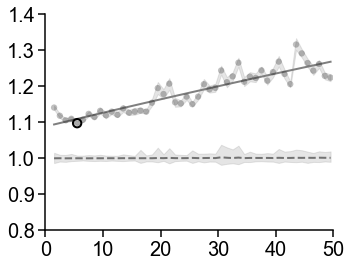

TEST


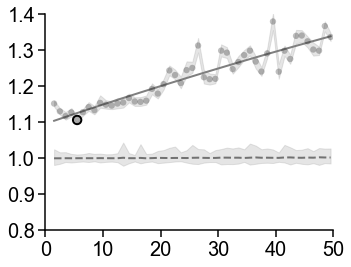

In [23]:
for split in splits.keys():
    print(split.upper())
    utilities.plot_stats_by_k(means, nulls, boots, circuit_counts, metric="mod",
                              split=split, op_k=6, clf=clf, interval=0.999, 
                              ylim=[0.8,1.4], yticks=[0.8, 0.9,1,1.1,1.2,1.3,1.4])